# Modular Control System Design

In this lecture we will:
- learn how to build up a controller made from simpler controllers (P, PI, PD, PID, Lead and Lag controllers) to meet design requirements
- learn which system characteristics we should focus on at different stages of the design process
- work through an example to illustrate the concepts

# Design Procedure

- We have learned how to use several controllers (P, PI, PD, PID, Lead, Lag). 
- Each controller is relatively simple. 
- We can use them together in series to meet design requirements for more complex systems or challenging design requirements


# What makes a system complex?

- unstable poles
- poles that are close to instability
- non-minumum phase zeros
- large delays

# Design Procedure

1. Explore open loop characteristics of system. This will help get indication of settling time, rise time, sensitivity to disturbances, what type of disturbances will likey happen, etc.
2. Explore what happens when you close the loop (in simulation). This will help get an indication of how whether instability is going to be a problem. This is often the case with "complex" systems.
3. If stability appears to be a problem design a controller to increase the robustness of the system.
4. Design a controller to meet the transient response or frequency domain requirements.
5. If the steady state error of the design is too large, design a Lag Controller to improve it. 

# Case Study - Two disks attached to a flexible rod

![2 Disk Graphic Diagram](2diskGraphic.png "2 Disk Graphic Diagram")

A torque is applied by a motor to a system with two disks. The disks are connected by a thin flexible rod. The rod is supported by bearings on both sides of the disks. The torque applied by the motor is known. The angular position of the right disk is measured. 



# Schematic Diagram
![2 Disk Schematic Diagram](2diskSchematic.png "2 Disk Schematic Diagram")

# 2 Rotating Disks Revisited

Earlier this semester, we had derived:
$$
\begin{align*}
\frac{V_2(s)}{T_M(s)} = \frac{1}{ \frac{J_1J_2}{k}s^3 + \frac{J_1b + J_2b}{k}s^3 + (J_1 + J_2 + \frac{b^2}{k}) s^2 + 2bs},  
\end{align*}
$$
where $v_2$ is the angular velocity of the second disk, and the $T_M$ is the torque applied by the motor. 


# Design Requirements

Suppose that we have attached a camera onto the end of the second disk. We want to use the camera for a security system. In order to track moving objects using the camera it has to be able to track references that move up to $5$ rad/s. In addition, in order to avoid blurry images, the system must be able to stabalize the second disk, even in the presence of disturbances such as unexpected bumps.

We must design a controller that is able to 
- stablize the second disk, even in the presence of disturbances such as unexpected bumps,
- track references that are slower than $5$ rad/s.




# Step 1 - Explore Open-Loop System

Want to get a preliminary idea of what the system is like:
- is it slow, fast?
- is it oscillatory?
- does it have a long or short settling time?
- how is it affected by distubances?


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import control as ct

J1 = 4
J2 = 3
k = 2
b = 1


P = ct.tf(1, [J1*J2/k, (J1+J2)*b/k, (J1+J2+b**2/k), 2*b])


print('Transfer Function of plant:\n', P)
print('\nPoles of plant:\n', P.poles())




Transfer Function of plant:
 
             1
---------------------------
6 s^3 + 3.5 s^2 + 7.5 s + 2


Poles of plant:
 [-0.14860038+1.06905524j -0.14860038-1.06905524j -0.28613257+0.j        ]


Text(0, 0.5, 'Angle (rad)')

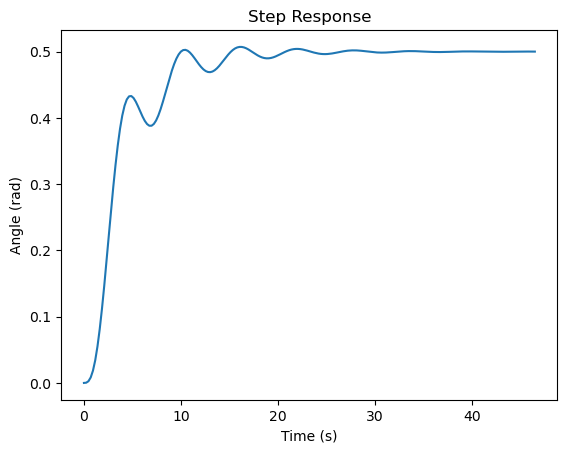

In [6]:
N = 1000
t = np.linspace(0,80,N)

t,y = ct.step_response(P)
fig, ax = plt.subplots(1)
ax.plot(t,y)
ax.set_title('Step Response')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angular Velocity (rad/s)')


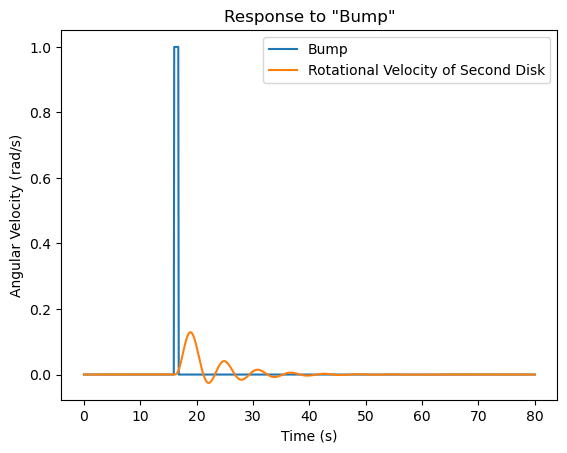

In [11]:
N = 1000
t = np.linspace(0,80,N)

bump2 = np.zeros(N)
bump2[200:210] = 1*np.ones(10)

t,y = ct.forced_response(P,T=t,U=bump2)
fig, ax = plt.subplots(1)
ax.plot(t,bump2, label='Bump')
ax.plot(t,y, label='Rotational Velocity of Second Disk')
ax.set_title('Response to "Bump"')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angular Velocity (rad/s)')
ax.legend()




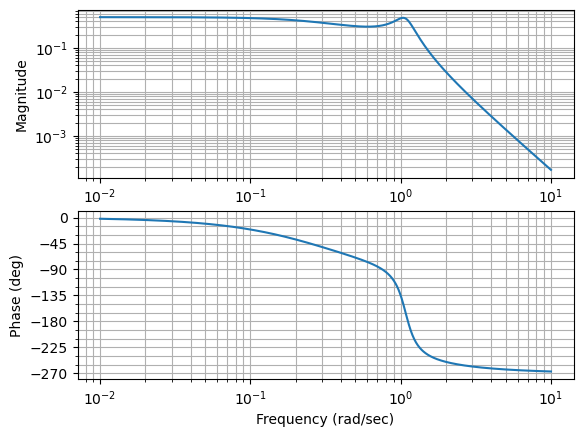

In [8]:
mag, phase, omega = ct.bode_plot(P)

# Observations

The plant $P(s)$:
- is highly oscillatory
- has poles very close to the imaginary axis (so it could be a complex system)
- long settling time
- sensitive to impulse disturbances

# Step 2 - Closing the Loop (in simulation)

Let's get an idea for how the system will act when we close the loop (controller is just $K(s) = 1$). 

This is just a preliminary exploration to determine if we are dealing with a "complex" system.

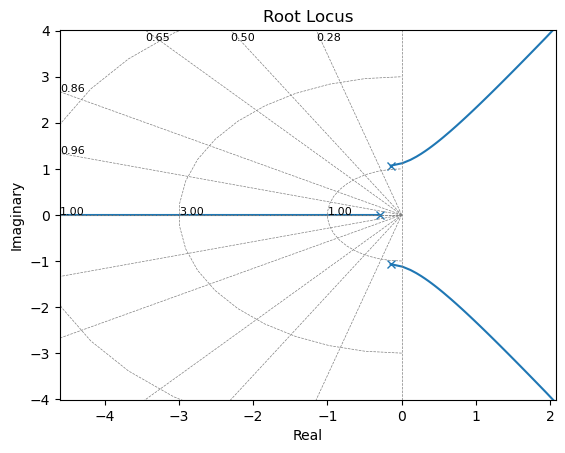

In [2]:
cl_poles, gain = ct.root_locus(P)

Maximum of Sensitivity: 1.788847714625351


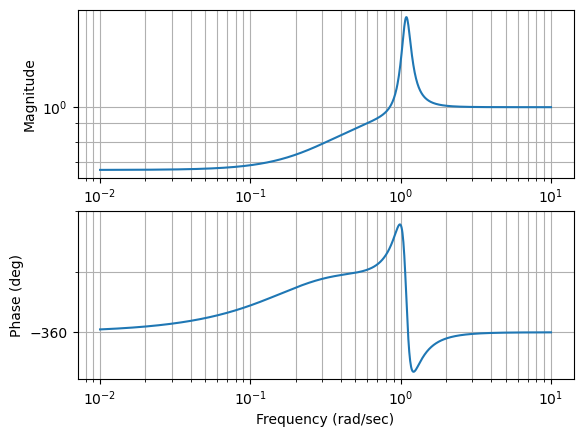

In [28]:
mag,phase,omega = ct.bode_plot(1/(1+P))
print('Maximum of Sensitivity:', np.max(mag))

Text(0.5, 0, 'Time (s)')

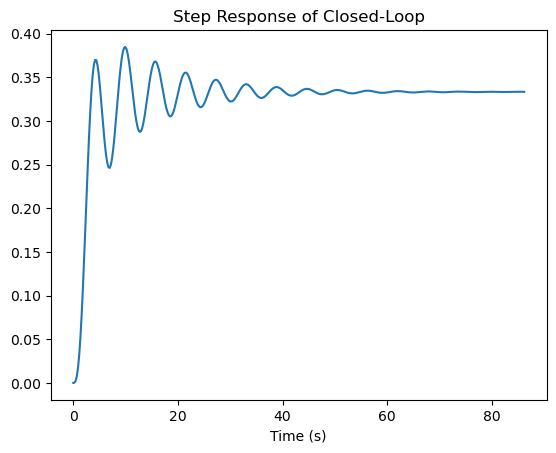

In [15]:
t,y = ct.step_response(P/(1+P))
fig,ax = plt.subplots(1)
ax.plot(t,y)
ax.set_title('Step Response of Closed-Loop')
ax.set_xlabel('Time (s)')


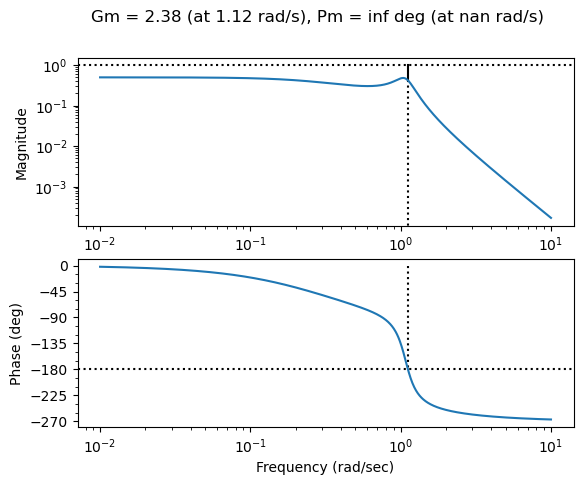

In [4]:
mag,phase,omega = ct.bode_plot(P,margins=True)

# Closing the loop might lead to stability issues

We can see this from each of the three plots above.
- In the Root Locus we see that the two open loop poles (that are already close to the imaginary axis) tend closer to the imaginary axis as $K$ increases, and quickly they cross the imaginary axis and become unstable. 
- In the Bode plot of the Sensitivity function with a unity controller ($\frac{1}{1+P}$)
- From the Bode Plot of $P$, we see that the gain margin is not that big.

Conclusion: we are dealing with a complex system.

# Step 3 - Increasing Robustness, and Chance of Instability

Before designing a controller to meet the design requirements, let's improve the robustness and reduce the chance of instability.

This will give us more freedom when designing the controller to meet the design requirements. 

# How can we increase the stability margins of a system?

- From closed-loop step response how would we decrease the oscillations?
- From Bode plot of $P$, how would we increase the gain margin?

# Answer

Use a PD controller!

Where should we place the zero?

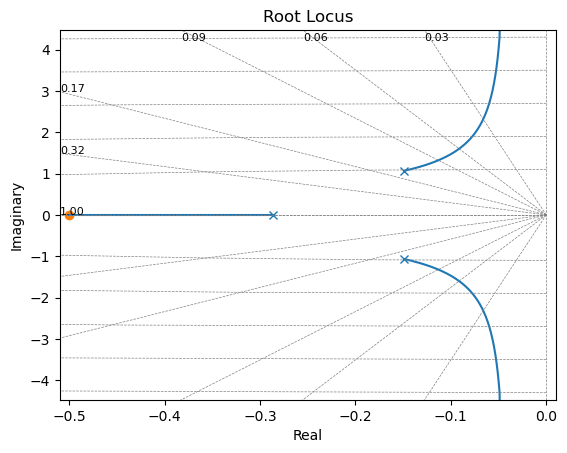

In [25]:
PD = ct.tf([1, 0.5], 1)

cl_poles, gain = ct.root_locus(P*PD)

Maximum of Sensitivity: 1.3259683010756838


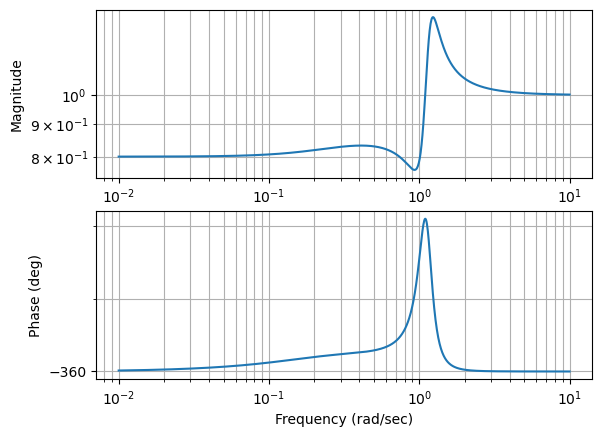

In [27]:
mag,phase,omega = ct.bode_plot(1/(1+P*PD))
print('Maximum of Sensitivity:', np.max(mag))

Text(0.5, 0, 'Time (s)')

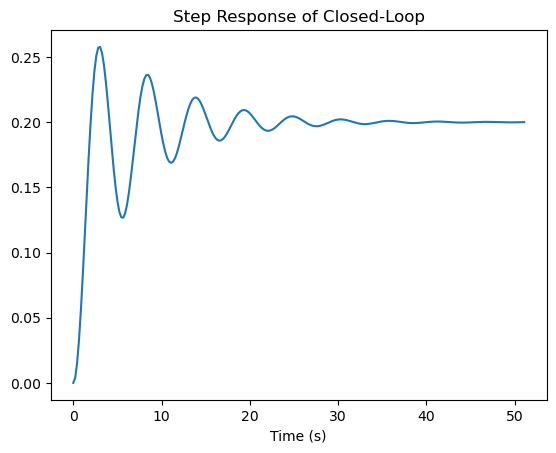

In [20]:
t,y = ct.step_response(P*PD/(1+P*PD))
fig,ax = plt.subplots(1)
ax.plot(t,y)
ax.set_title('Step Response of Closed-Loop')
ax.set_xlabel('Time (s)')


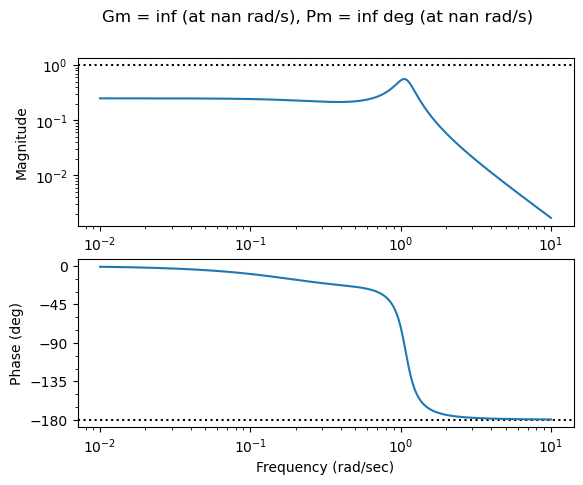

In [22]:
mag,phase,omega = ct.bode_plot(P*PD,margins=True)

# Observation

Our system is much more robust now! We have infinite gain margin, and so we are less likely to run into stability issues now. 

# Step 4 - Meeting design objectives

# First Design Requirement: Disturbance Rejection

The effect of disturbances on the closed-loop system is governed by the transfer function $\frac{P(s)}{1 + P(s)K(s)}$. We want this transfer function to be small for all frequencies:
- we don't know at what frequency the common disturbances can occur
- bumps, or impulses have frequency content at all frequencies. The Laplace Transform of an impulse $\delta(t)$ is $1$. In other words, it is a constant for all frequencies (i.e. non-zero for all frequencies).



Cross over frequency: 2.7066520700332415


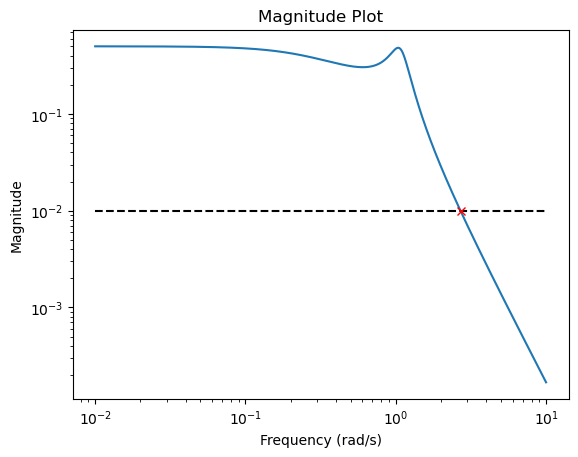

In [34]:

mag, phase, omega = ct.bode_plot(P, plot=False)
fig, ax = plt.subplots(1)
ax.loglog(omega,mag)
ax.plot([0.01, 10], [0.01, 0.01], 'k--')
ax.set_title('Magnitude Plot')
ax.set_xlabel('Frequency (rad/s)')
ax.set_ylabel('Magnitude')

omegaX = [ii for ii,vv in enumerate(mag) if vv < 0.01]
omegaX = omegaX[0]

ax.plot(omega[omegaX], mag[omegaX], 'rx')
print('Cross over frequency:', omega[omegaX])



# Observations

- From the Bode Plot of the plant, we notice that it is small ($<0.01$) for all frequencies greater than $0.27$ rad/s.
- We want to make $\frac{P(s)}{1 + P(s)K(s)} = $P(s)S(s)$ small. Only $S(s)$ is a function of $K(s)$. 
- Design sensitivity, $S(s)$, such that it is small for frequencies $< 0.27$ rad/s. 
- We know how to do this because $S(s)$ is directly related to the closed-loop poles. 

#  Second Design Requirement: Reference Tracking

We want to be able to track references with frequency content between $0-5$ rad/s. This means we want the sensitivity function to be small for frequencies $0-5$ rad/s. 

Note that this condition essentially incorporates/supercedes the previous condition as well (if we meet this condition, we will automatically meet the disturbance rejection condition). 

# Where to Place the Poles?

The sensitivity function is equal to:
$$
\begin{align*}
S(s) &= \frac{1}{1 + P(s)PD(s)K(s)} \\
&= \frac{1}{1 + \frac{B_P(s)}{A_P(s)}(s+0.5)\frac{B_K(s)}{A_K(s)}} \\
&= \frac{A_K(s)A_P(s)}{A_K(s)A_P(s) + (s+0.5)B_K(s)B_P(s)} \\
&= \frac{A_K(s)A_P(s)}{A_{cl}(s)}
\end{align*}
$$

The zeros of the sensitivity function are equal to the poles of the plant plus the poles of the controller. In this case the poles of the plant are:
$$ 
-0.149 \pm j1.07, -0.286      
$$
which have absolute values
$$
1.08, 1.08, 0.286.
$$
Observations:
- all zeros of the sensitivity function have absolute value less than $5$. 
- therefore, we can attempt to shape the sensitivity by "bending it down" at $5$ rad/s, which is our desired bandwidth. 
- therefore, we want to attempt to place the closed loop poles at a location such that their absolute value is equal to $5$. 

Complex poles that have absolute value equal to $5$:
$$
\begin{align*}
\sqrt{\alpha^2 + \beta^2} &= 5 \\
\alpha^2 + \beta^2 &= 25 
\end{align*}
$$
Choose $\alpha=\beta$. This is quite a robust choice since it will result in no resonance peak:
$$
\begin{align*}
2 \alpha^2 &= 25 \\
\alpha &= \sqrt{12.5} \\
\alpha &= 3.54.
\end{align*}
$$

# Conclusion:

In this step we want to design a controller that will place the (dominant) closed-loop poles at $-3.54 \pm 3.54$.

# Design a Lead Compensator

Design a lead compensator to attempt to place closed-loop poles at $-3.54 \pm 3.54$

Step 1 of Lead Compensator Design: Need to calculate the phase at $-3.54 \pm 3.54$

In [37]:
a = complex(-3.54,3.54)
  
p1 = complex(-0.15, 1.07)
p2 = complex(-0.15, -1.07)
p3 = -0.286
z1 = -0.5

M1 = np.abs(a-p1)
angle1 = np.angle(a-p1)

M2 = np.abs(a-p2)
angle2 = np.angle(a-p2)

M3 = np.abs(a-p3)
angle3 = np.angle(a-p3)

M5 = np.abs(a-z1)
angle5 = np.angle(a-z1)

print('Pole 1:')
print('mag:', M1)
print('phase:', angle1*180/np.pi)

print('\nPole 2:')
print('mag:', M2)
print('phase:', angle2*180/np.pi)

print('\nPole 3:')
print('mag:', M3)
print('phase:', angle3*180/np.pi)

print('\nZero 1:')
print('mag:', M5)
print('phase:', angle5*180/np.pi)

print('\nTotal phase at', a, ':', (angle5 - angle1 - angle2 - angle3)*180/np.pi, 'degrees.')



Pole 1:
mag: 4.1944010299445615
phase: 143.92241122064303

Pole 2:
mag: 5.722254800338762
phase: 126.32919854640906

Pole 3:
mag: 4.80833817446319
phase: 132.58950193990427

Zero 1:
mag: 4.666176164698457
phase: 130.65456825077092

Total phase at (-3.54+3.54j) : -272.18654345618546 degrees.


Therefore, we need to add $92$ degrees of phase in order to modify the root locus so that it passes through the points $-3.54 \pm j3.54$. 

To acheive this objective, will need two Lead Compensators. Each compensator needs to add $46$ degrees of phase.

# In Class Activity

Step 2 of Lead Compensator Design: place pole and zero of lead compensator so that together they add enough phase so that the phase at the desired closed-loop pole location is $-180$ degrees.

Place the Lead compensator zero so that it adds 55 degrees of phase.

What is the resulting Lead Compensator?

In [38]:
Kld_z = np.imag(a)/math.tan(55*np.pi/180) - np.real(a)
print('Location of Lead Compensator zero:', Kld_z)
phase_pole = 55-46
Kld_p = np.imag(a)/math.tan(phase_pole*np.pi/180)-np.real(a)
print('Location of Lead Compensator pole:', Kld_p)

Location of Lead Compensator zero: 6.018734685262373
Location of Lead Compensator pole: 25.890680361949656


# Lead Compensator

The resulting lead compensator is 
$$
K(s) = K_{ld}\frac{s+6.02}{s+25.89}
$$

Step 3 of Lead Compensator Design: determine the gain of the compensator $K_{ld}$. Recall that in order for a point to be a closed-loop zero, it must have a magnitude of $1$. 

In [51]:
a = complex(-np.sqrt(25/2),np.sqrt(25/2))
 
#pk = complex(-27.22, 0)
#zk = complex(-13.26, 0)
pk = complex(-Kld_p, 0)
zk = complex(-Kld_z, 0)

Mpk = np.abs(a-pk)
angle_pk = np.angle(a-pk)

Mzk = np.abs(a-zk)
angle_zk = np.angle(a-zk)

M = Mzk*Mzk*M5/Mpk/Mpk/M1/M2/M3

print('Total phase at', a, ':', (angle5 - angle1 - angle2 - angle3 + 2*angle_zk - 2*angle_pk)*180/np.pi, 'degrees.')
print('Total Magnitude at', a, ':', M)
print('Kld = ', 1/M)



Total phase at (-3.5355339059327378+3.5355339059327378j) : 179.81345654381457 degrees.
Total Magnitude at (-3.5355339059327378+3.5355339059327378j) : 0.001474568074702238
Kld =  678.1646891425692


# Lead Compensator (continued)

The resulting lead compensator is 
$$
K(s) = \sqrt{678}\frac{s+6.02}{s+25.89}
$$
# Check our design using Python

(-10.0, 10.0)

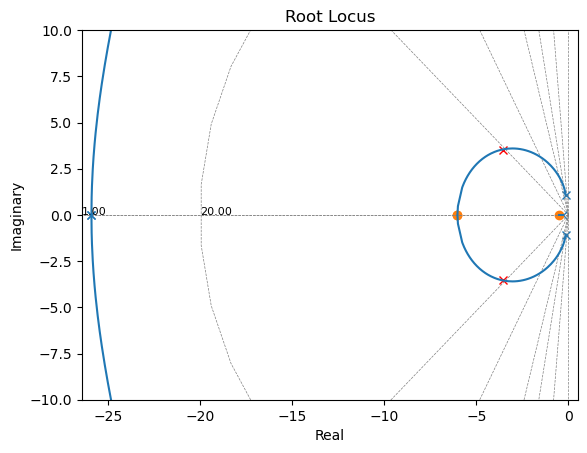

In [40]:
Kld = np.sqrt(678)
PD = ct.tf([1, 0.5], 1)
K = ct.tf([Kld, Kld*6.02], [1, 25.89])

fig, ax = plt.subplots(1)
cl_poles, gain = ct.root_locus(P*K*K*PD)
ax.plot(-3.54,3.54,'rx')
ax.plot(-3.54,-3.54,'rx')
ax.set_ylim(-10,10)


In [41]:
L = 6*P*K*K*PD

S = 1/(1+L)
T = L/(1+L)

print('Poles of Sensitivity Function, S:\n', S.poles())

Poles of Sensitivity Function, S:
 [-22.39458889+22.59149399j -22.39458889-22.59149399j
  -3.54111652 +3.54827734j  -3.54111652 -3.54827734j
  -0.49192251 +0.j        ]


# Verfiy The Design - Are Design Requirements Met?

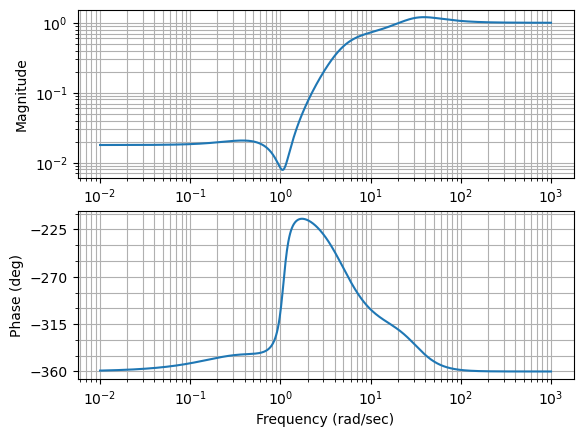

In [42]:
mag,phase,omega = ct.bode_plot(S)

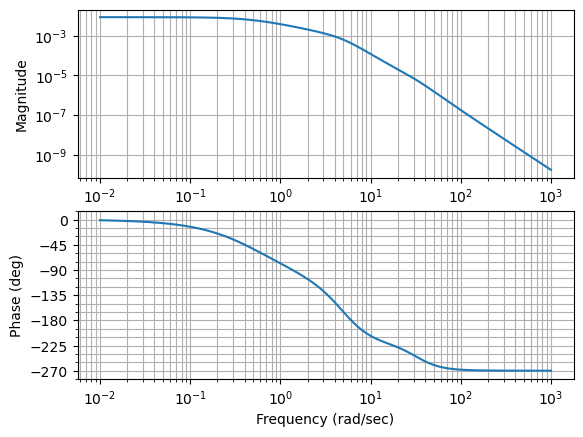

In [43]:
mag,phase,omega = ct.bode_plot(S*P)

Text(42.597222222222214, 0.5, 'Torque')

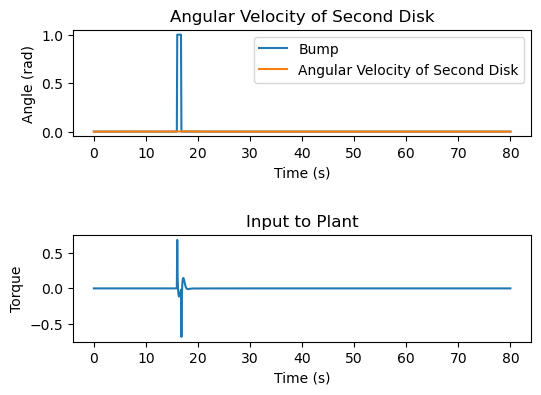

In [49]:
t = np.linspace(0,80,N)
t,y = ct.forced_response(S*P,T=t,U=bump2)
t,u = ct.forced_response(S,T=t,U=bump2)
fig, ax = plt.subplots(2,1)
fig.tight_layout(pad=5.0)
ax[0].plot(t,bump2, label='Bump')
ax[0].plot(t,y, label='Angular Velocity of Second Disk')
ax[0].set_title('Angular Velocity of Second Disk')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (rad)')
ax[0].legend()

ax[1].plot(t,u, label='Input Torque')
ax[1].set_title('Input to Plant')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Torque')

Text(37.597222222222214, 0.5, 'Torque')

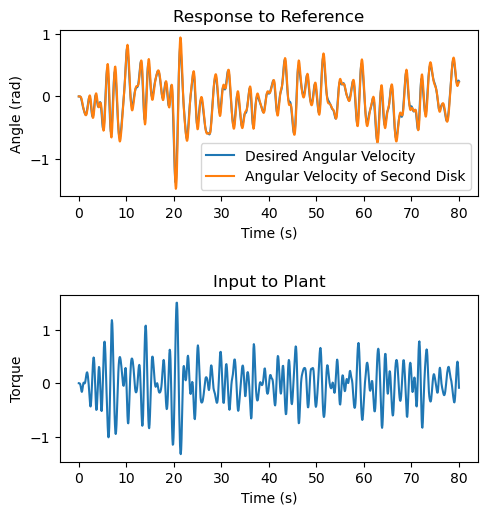

In [52]:
import scipy as sp

b1, a1 = sp.signal.butter(5, 0.1, 'low')
r = sp.signal.lfilter(b1, a1, np.random.randn(N))


t,y = ct.forced_response(T,T=t,U=r)
t,u = ct.forced_response(K*S,T=t,U=r)
fig, ax = plt.subplots(2,1, figsize=(6,6))
fig.tight_layout(pad=5.0)
ax[0].plot(t,r, label='Desired Angular Velocity')
ax[0].plot(t,y, label='Angular Velocity of Second Disk')
ax[0].set_title('Response to Reference')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (rad)')
ax[0].legend()

ax[1].plot(t,u, label='Input Torque')
ax[1].set_title('Input to Plant')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Torque')


Text(37.597222222222214, 0.5, 'Torque')

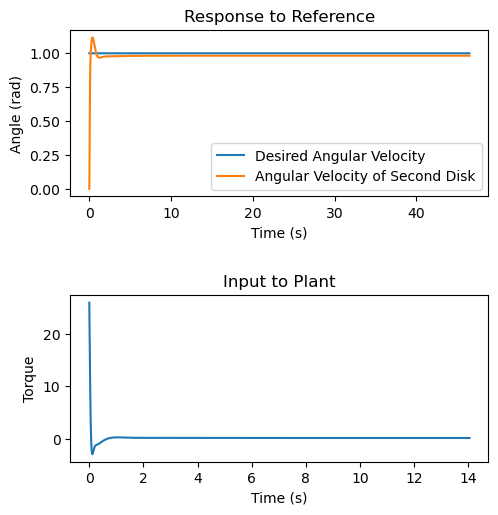

In [58]:
t1,y = ct.step_response(T)
t2,u = ct.step_response(S*K)

fig, ax = plt.subplots(2,1, figsize=(6,6))
fig.tight_layout(pad=5.0)
ax[0].plot(t1,np.ones(t1.shape[0]), label='Desired Angular Velocity')
ax[0].plot(t1,y, label='Angular Velocity of Second Disk')
ax[0].set_title('Response to Reference')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (rad)')
ax[0].legend()

ax[1].plot(t2,u, label='Input Torque')
ax[1].set_title('Input to Plant')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Torque')

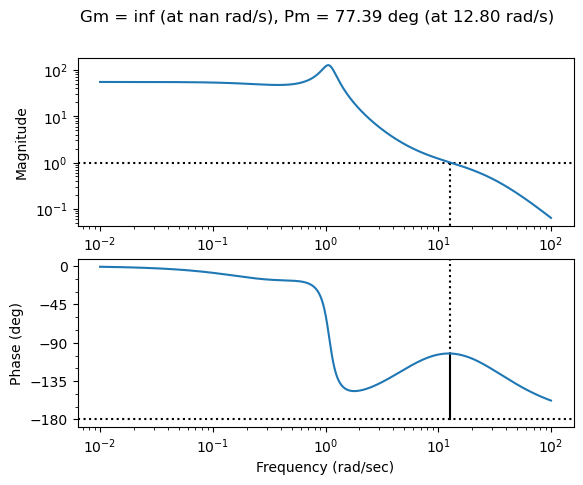

In [53]:
mag,phase,omega = ct.bode_plot(L,margins=True)

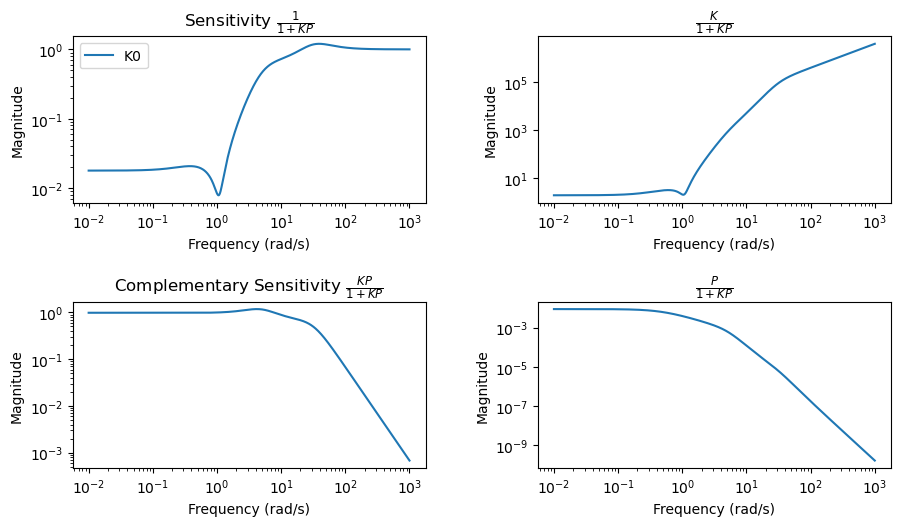

In [54]:
def plot_gang_of_four(P,K):
    num_sys = len(K)
    fig, ax = plt.subplots(2,2, figsize=(10,6))
    fig.tight_layout(pad=5.0)

    for ii in range(num_sys):
        T = P*K[ii]/(1+P*K[ii])
        S = 1/(1+P*K[ii])
        SK = K[ii]*S 
        SP = P*S 

        mag_S, phase_S, w_S = ct.bode_plot(S,plot=False)
        mag_T, phase_T, w_T = ct.bode_plot(T,plot=False)
        mag_SK, phase_SK, w_SK = ct.bode_plot(SK,plot=False)
        mag_SP, phase_SP, w_SP = ct.bode_plot(SP,plot=False)

        label_str = 'K' + str(ii)
        ax[0,0].loglog(w_S,mag_S, label=label_str)
        ax[0,0].set_title(r'Sensitivity $\frac{1}{1+KP}$')
        ax[0,0].legend()
        ax[0,0].set_xlabel('Frequency (rad/s)')
        ax[0,0].set_ylabel('Magnitude')
       
        ax[1,0].loglog(w_T,mag_T)
        ax[1,0].set_title(r'Complementary Sensitivity $\frac{KP}{1+KP}$')
        ax[1,0].set_xlabel('Frequency (rad/s)')
        ax[1,0].set_ylabel('Magnitude')

        ax[0,1].loglog(w_SK,mag_SK)
        ax[0,1].set_title(r'$\frac{K}{1+KP}$')
        ax[0,1].set_xlabel('Frequency (rad/s)')
        ax[0,1].set_ylabel('Magnitude')

        ax[1,1].loglog(w_SP,mag_SP)
        ax[1,1].set_title(r'$\frac{P}{1+KP}$')
        ax[1,1].set_xlabel('Frequency (rad/s)')
        ax[1,1].set_ylabel('Magnitude')

    return fig, ax

fig, ax = plot_gang_of_four(P,[6*PD*K*K])

# Step 5 in Design Process - Check Steady State Error

In our case, the steady state error is already quite small. No need for a Lag Compensator.

# Our Design in Complete!